In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

!pip install ogb
!pip install rdkit-pypi

## Importamos las librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# For Dataset generation and visualization
from rdkit import Chem
# from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem import Draw
# IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs
from ogb.graphproppred.mol_encoder import AtomEncoder
from ogb.utils.features import atom_to_feature_vector, bond_to_feature_vector

# Extras
import os.path as osp
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder
from sklearn.metrics import precision_score
from sklearn.metrics import matthews_corrcoef
from math import sqrt


## Dataset visualization

In [ ]:
csv_path = '/content/drive/MyDrive/GNN/ampc/training_ds.csv'
molecules = pd.read_csv(csv_path).sample(10).values

## Data Handling of Graphs

In [3]:
# Pytorch geometric modules
from torch_geometric.data import Data, Dataset, InMemoryDataset
from torch_geometric.loader import DataLoader

# Torch
import torch

class moleculesDS(InMemoryDataset):
  def __init__(self, root, csv_path, transform=None, pre_transform=None):
    self.csv_path = csv_path
    super().__init__(root, transform, pre_transform)
    self.data, self.slices = torch.load(self.processed_paths[0])

  @property
  def raw_file_names(self):
    return []

  @property
  def processed_file_names(self):
    # After preprocesing usinf comment columns and NOT Decoys
    files = 'final_v2.pt'
    return files


  def download(self):
    pass

  def process(self):
    data_list = []
    molecules = pd.read_csv(self.csv_path).values

    for smiles, act in molecules:
        y = torch.tensor(act, dtype=torch.float32).reshape(-1, 1)
        
        # Throw molecules in wich molecules can not be obtanined
        try:
            mol = Chem.MolFromSmiles(smiles)
        except:
            mol = None
        if mol is None:
            print('mol is none')
            continue

        all_node_feats = []
        for atom in mol.GetAtoms():
            node_feats = atom_to_feature_vector(atom)
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        x = torch.tensor(all_node_feats, dtype=torch.long).view(-1, 9)

        edge_attr = []
        edge_index = []
        for bond in mol.GetBonds():

            bond_feats = bond_to_feature_vector(bond)
            edge_attr.append([bond_feats, bond_feats])

            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_index += [[i, j], [j, i]]


        edge_attr = torch.tensor(edge_attr)
        edge_attr = edge_attr.to(torch.long).view(-1, 3)

        edge_index = torch.tensor(edge_index)
        edge_index = edge_index.t().to(torch.long).view(2, -1)


        data = Data(x=x, edge_index=edge_index, edge_attr = edge_attr, y=y.reshape(1, 1), smiles=smiles)

        data_list.append(data)

    data, slices = self.collate(data_list)
    torch.save((data, slices), self.processed_paths[0])


---

# Model

In [4]:
from torch_geometric.nn import GATv2Conv, GCNConv
from torch_geometric.nn import global_mean_pool, BatchNorm

from torch.nn import Sequential, ModuleList, ReLU, Linear, Dropout
import torch.nn.functional as F

from torch_geometric.nn.models import AttentiveFP

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, dropout):
        super(GCN, self).__init__()
        torch.manual_seed(12345)

        self.emb = AtomEncoder(in_channels)
        self.bondemb = BondEncoder(3)

        self.AttentiveFP = AttentiveFP(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=1,
                     edge_dim=3, num_layers=num_layers, num_timesteps=1, dropout=dropout)
        
        
    def forward(self, x, edge_index, edge_attr, batch_index):
        x = self.emb(x)
        edge_attr = self.bondemb(edge_attr)
        x = self.AttentiveFP(x, edge_index, edge_attr, batch_index)
        return x

# Training

In [11]:
from sklearn.metrics import precision_score, matthews_corrcoef, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import rdkit.Chem as Chem
from rdkit.Chem import AllChem

from statistics import mean

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device is: {DEVICE}')


def get_metrics(y_true, y_pred):
    y_pred = np.rint(y_pred)

    precision = precision_score(y_true, y_pred)
    matthews = matthews_corrcoef(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    return precision, matthews, accuracy


def training_step(model, x, edge_index, edge_attr, batch_index, y_target, criterion, optimizer):
    model.train()
    optimizer.zero_grad()

    h = model(x, edge_index, edge_attr, batch_index)

    loss = criterion(h.reshape(-1), y_target.reshape(-1))
    loss.backward()

    optimizer.step()

    return float(loss), h


@torch.no_grad()
def test_step(model, x, edge_index, edge_attr, batch_index, y_target, criterion):
    model.eval()

    h = model(x, edge_index, edge_attr, batch_index)

    loss = criterion(h, y_target)

    return float(loss), h


def epoch(model, dataloader, criterion, optimizer, training=True):

    total_loss = 0
    total_examples = 0

    y_target_list = []
    h_list = []

    for data in dataloader:
        data = data.to(DEVICE)
        y_target = data.y
        x, edge_index, edge_attr, batch_index = data.x, data.edge_index, data.edge_attr, data.batch

        y_target = y_target.reshape(-1, 1)

        if training:
            loss, h = training_step(model, x, edge_index, edge_attr, batch_index, y_target, criterion, optimizer)
        else:
            loss, h = test_step(model, x, edge_index, edge_attr, batch_index, y_target, criterion)

        total_loss += loss * len(y_target)
        total_examples += len(y_target)

        y_target_list.append(y_target)
        h_list.append(h)

    y_true = torch.cat(y_target_list, dim=0).detach().cpu().numpy()
    y_pred = torch.sigmoid(torch.cat(h_list, dim=0)).detach().cpu().numpy()

    precision_score, matthews_corrcoef, accuracy = get_metrics(y_true, y_pred)

    return total_loss/total_examples, precision_score, matthews_corrcoef, accuracy


def training_init(EPOCHS, model, dataloaders, criterion, optimizer):
    train_metrics = []
    test_metrics = []
    test_precision_score_list = []

    train_dataloader, test_dataloader = dataloaders

    for e in range(EPOCHS):
        train_total_loss, train_precision_score, train_matthews_corrcoef, train_accuracy = epoch(
            model, train_dataloader, criterion, optimizer)
        train_metrics.append([train_total_loss, train_precision_score, train_matthews_corrcoef, train_accuracy])

        test_total_loss, test_precision_score, test_matthews_corrcoef, test_accuracy = epoch(
            model, test_dataloader, criterion, optimizer, training=False)
        test_metrics.append([test_total_loss, test_precision_score, test_matthews_corrcoef, test_accuracy])
        test_precision_score_list.append(test_precision_score)

        if e % 20 == 0:
            print(f'Epoch {e}')
            print(f'loss {train_total_loss:.4f} | precision_score {train_precision_score:.4f} | matthews_corrcoef {train_matthews_corrcoef:.4f} | accuracy {train_accuracy:.4f}')
            print(f'loss {test_total_loss:.4f} | precision_score {test_precision_score:.4f} | matthews_corrcoef {test_matthews_corrcoef:.4f} | accuracy {test_accuracy:.4f}')
            print()

    # For optimization
    test_precision_score = mean(test_precision_score_list[-10:])
    return test_precision_score, (train_metrics, test_metrics)

def get_dataset_and_weight(root, file_name, batch_size, shuffle=True):
    dataset = moleculesDS(root = root, csv_path = file_name)
    loader = DataLoader(dataset, batch_size = batch_size, shuffle=True)

    pos_weight = len(dataset.data.y.reshape(-1)) / dataset.data.y.reshape(-1).sum()
    pos_weight = torch.Tensor([pos_weight])
    print(f'El número de valores en el dataset es de: {len(dataset.data.y.reshape(-1))} y tiene {dataset.data.y.sum()} positivos')
    return loader, pos_weight

def get_model_criterion_optimizer(pos_weight, lr, hidden_channels, num_layers, dropout, weight_decay = 1**-6):
    model = GCN(9, hidden_channels, num_layers, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight = pos_weight)
    return model, criterion, optimizer

# For Optuna
# - - - - - - - - - - - - - - - - - - - - - - - - 

# Variables with the commented trial.suggest... are the optimum value of first experiment
def get_model_criterion_optimizer_for_optuna(trial, weight):
    lr = 0.0015294022249668856 #trial.suggest_float("lr", 1e-6, 1e-2, log=True, )
    weight_decay = trial.suggest_float("weight_decay", 1e-7, 1e-4, log=True)
    num_layers = 2 #trial.suggest_int('num_layers', 2, 5, step=1)
    hidden_channels = 320 # trial.suggest_int('hidden_channels', 20, 520, step=100)
    dropout = trial.suggest_float("dropout", 0.45, 0.55, step=0.05)
    return get_model_criterion_optimizer(weight, lr, hidden_channels, num_layers, dropout, weight_decay = weight_decay)

# - - - - - - - - - - - - - - - - - - - - - - - - 
def get_all_optuna(trial, root, file_name, batch_size, shuffle=True):
    dataloader, weight = get_dataset_and_weight(root, file_name, batch_size, shuffle=shuffle)

    model, criterion, optimizer = get_model_criterion_optimizer_for_optuna(
        trial, weight)

    return model, criterion, optimizer, dataloader

Device is: cuda


El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Epoch 0
loss 1.9710 | precision_score 0.0852 | matthews_corrcoef 0.0189 | accuracy 0.4959
loss 1.0388 | precision_score 0.0380 | matthews_corrcoef 0.0127 | accuracy 0.0420

Epoch 20
loss 0.7069 | precision_score 0.3222 | matthews_corrcoef 0.4435 | accuracy 0.8493
loss 0.5299 | precision_score 0.1933 | matthews_corrcoef 0.3469 | accuracy 0.8680

Epoch 40
loss 0.4907 | precision_score 0.4378 | matthews_corrcoef 0.5833 | accuracy 0.8994
loss 0.4402 | precision_score 0.2361 | matthews_corrcoef 0.4318 | accuracy 0.8843

Epoch 60
loss 0.2929 | precision_score 0.5564 | matthews_corrcoef 0.7001 | accuracy 0.9353
loss 0.3798 | precision_score 0.3667 | matthews_corrcoef 0.5487 | accuracy 0.9376

Epoch 80
loss 0.2596 | precision_score 0.6192 | matthews_corrcoef 0.7424 | accuracy 0.9491
loss 0.4175 | precision_score 0.3947 | matthews_corrcoef 0.5430 | accuracy

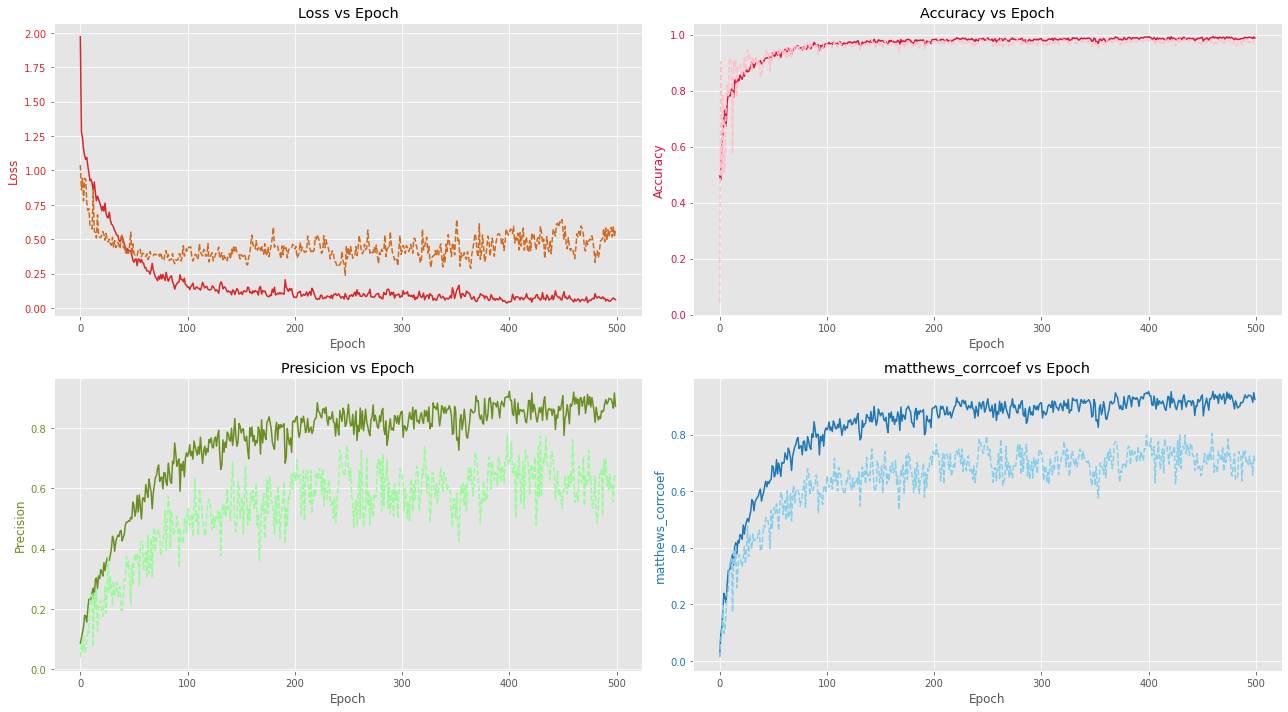

In [15]:
'''
{
    'lr': 0.0015294022249668856, 
    'num_layers': 2, 
    'hidden_channels': 320
}

'''
'''
# optimizing with wd and dropout
wd = 2.3820455190468508e-05
dropout = 0.45
'''

if __name__ == '__main__':
    batch_size_train = 500
    batch_size_test = 150

    root = '/content/drive/MyDrive/GNN/training'
    train_file_name = '/content/drive/MyDrive/ampc_fp_optuna/test_ds_mk.csv' 
    train_dataloader, weight = get_dataset_and_weight(
        root, train_file_name, batch_size_train, shuffle=True)

    root = '/content/drive/MyDrive/GNN/testing'
    test_file_name = '/content/drive/MyDrive/ampc_fp_optuna/test_ds_mk.csv' 
    test_dataloader, _ = get_dataset_and_weight(
        root, test_file_name, batch_size_test, shuffle=False)

    num_layers = 2
    hidden_channels = 320
    dropout = 0.45
    lr = 0.0015294022249668856 # learning was inestable, so small rl will be try
    weight_decay = 2.3820455190468508e-05
    model, criterion, optimizer = get_model_criterion_optimizer(
        weight, lr, hidden_channels, num_layers, dropout, weight_decay=weight_decay)
    
    # Generate the model.
    model = model.to(DEVICE)
    criterion = criterion.to(DEVICE)

    # Training init
    EPOCHS = 200
    _, metrics = training_init(EPOCHS, model, [train_dataloader,
                  test_dataloader], criterion, optimizer)
    
    # Metrics unpacking
    train_metrics, test_metrics = metrics
    train_metrics, test_metrics = np.array(train_metrics), np.array(test_metrics)

    train_total_loss, train_precision_score, train_matthews_corrcoef, train_accuracy = train_metrics[:,0], train_metrics[:,1], train_metrics[:,2], train_metrics[:,3]
    test_total_loss, test_precision_score, test_matthews_corrcoef, test_accuracy = test_metrics[:,0], test_metrics[:,1], test_metrics[:,2], test_metrics[:,3]

    # Taken from matplotlib documentation
    fig, ax1 = plt.subplots(2, 2, figsize=(18,10))
    t = range(EPOCHS)


    # Loss
    ax1[0, 0].set_title('Loss vs Epoch')
    ax1[0, 0].set_xlabel('Epoch')
    ax1[0, 0].set_ylabel('Loss', color='tab:red')
    ax1[0, 0].tick_params(axis='y', labelcolor='tab:red')
    ax1[0, 0].plot(t, train_total_loss, color='tab:red')
    ax1[0, 0].plot(t, test_total_loss, color='chocolate', linestyle='dashed')

    # Presicion
    ax1[1, 0].set_title('Presicion vs Epoch')
    ax1[1, 0].set_xlabel('Epoch')
    ax1[1, 0].set_ylabel('Precision', color='olivedrab')  
    ax1[1, 0].tick_params(axis='y', labelcolor='olivedrab')

    ax1[1, 0].plot(t, train_precision_score, color='olivedrab')
    ax1[1, 0].plot(t, test_precision_score, color='palegreen', linestyle='dashed')

    # matthews_corrcoef
    ax1[1, 1].set_title('matthews_corrcoef vs Epoch')
    ax1[1, 1].set_xlabel('Epoch')
    ax1[1, 1].set_ylabel('matthews_corrcoef', color='tab:blue')  
    ax1[1, 1].tick_params(axis='y', labelcolor='tab:blue')

    ax1[1, 1].plot(t, train_matthews_corrcoef, color='tab:blue')
    ax1[1, 1].plot(t, test_matthews_corrcoef, color='skyblue', linestyle='dashed')

    # Accuracy
    ax1[0, 1].set_title('Accuracy vs Epoch')
    ax1[0, 1].set_ylabel('Accuracy', color='crimson')  
    ax1[0, 1].set_xlabel('Epoch')
    ax1[0, 1].tick_params(axis='y', labelcolor='crimson')

    ax1[0, 1].plot(t, train_accuracy, color='crimson')
    ax1[0, 1].plot(t, test_accuracy, color='pink', linestyle='dashed')

    fig.tight_layout() 
    plt.show()


## Overfitting
Looks like the model is overfitting in epoch 150-200. So the final plot is:

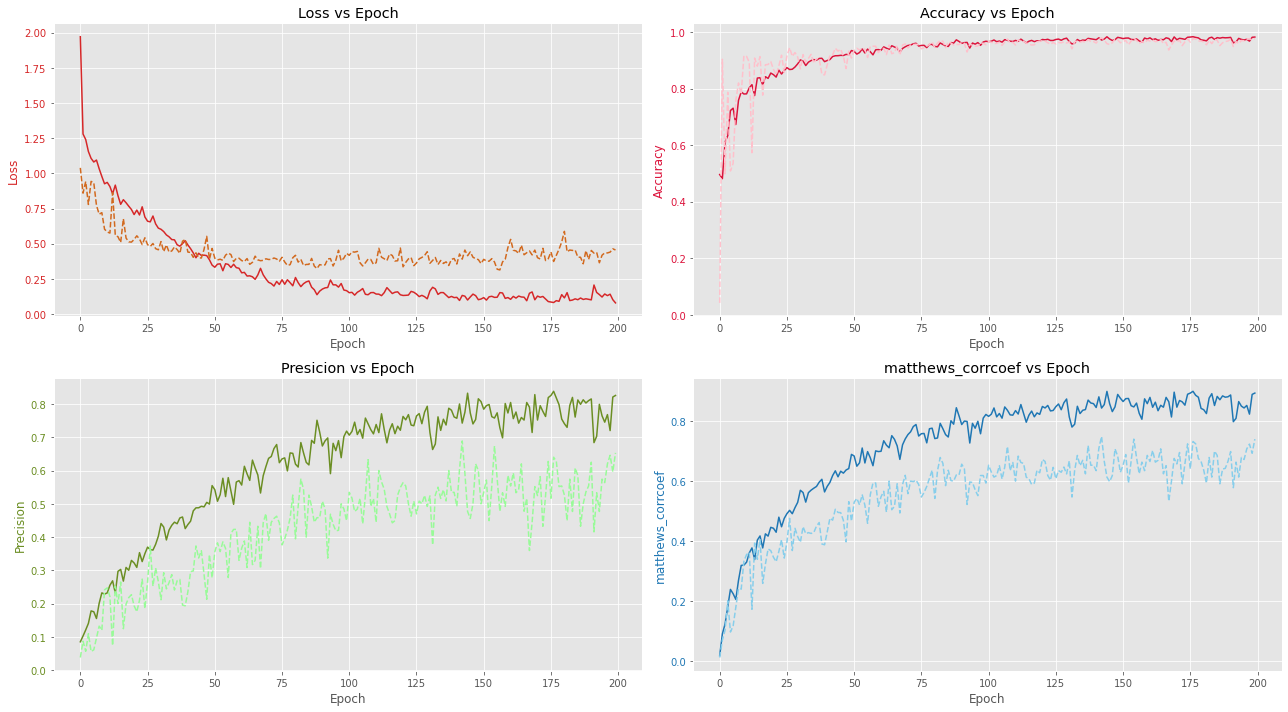

In [17]:
# Taken from matplotlib documentation
fig, ax1 = plt.subplots(2, 2, figsize=(18,10))
t = list(range(EPOCHS))[0:200]


# Loss
ax1[0, 0].set_title('Loss vs Epoch')
ax1[0, 0].set_xlabel('Epoch')
ax1[0, 0].set_ylabel('Loss', color='tab:red')
ax1[0, 0].tick_params(axis='y', labelcolor='tab:red')
ax1[0, 0].plot(t, train_total_loss[0:200], color='tab:red')
ax1[0, 0].plot(t, test_total_loss[0:200], color='chocolate', linestyle='dashed')

# Presicion
ax1[1, 0].set_title('Presicion vs Epoch')
ax1[1, 0].set_xlabel('Epoch')
ax1[1, 0].set_ylabel('Precision', color='olivedrab')  
ax1[1, 0].tick_params(axis='y', labelcolor='olivedrab')

ax1[1, 0].plot(t, train_precision_score[0:200], color='olivedrab')
ax1[1, 0].plot(t, test_precision_score[0:200], color='palegreen', linestyle='dashed')

# matthews_corrcoef
ax1[1, 1].set_title('matthews_corrcoef vs Epoch')
ax1[1, 1].set_xlabel('Epoch')
ax1[1, 1].set_ylabel('matthews_corrcoef', color='tab:blue')  
ax1[1, 1].tick_params(axis='y', labelcolor='tab:blue')

ax1[1, 1].plot(t, train_matthews_corrcoef[0:200], color='tab:blue')
ax1[1, 1].plot(t, test_matthews_corrcoef[0:200], color='skyblue', linestyle='dashed')

# Accuracy
ax1[0, 1].set_title('Accuracy vs Epoch')
ax1[0, 1].set_ylabel('Accuracy', color='crimson')  
ax1[0, 1].set_xlabel('Epoch')
ax1[0, 1].tick_params(axis='y', labelcolor='crimson')

ax1[0, 1].plot(t, train_accuracy[0:200], color='crimson')
ax1[0, 1].plot(t, test_accuracy[0:200], color='pink', linestyle='dashed')

fig.tight_layout() 
plt.show()

## Optuna hyperparameter search

In [6]:
!pip install optuna

     |████████████████████████████████| 308 kB 5.4 MB/s 
     |████████████████████████████████| 80 kB 8.5 MB/s 
     |████████████████████████████████| 209 kB 39.6 MB/s 
     |████████████████████████████████| 75 kB 4.2 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 112 kB 43.9 MB/s 
     |████████████████████████████████| 149 kB 40.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=c22ac64341e14ecbfd940cb06a631284cf54356ff9b773221fd0047b1692ea88
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [7]:
import torch
import optuna
import pandas as pd
from optuna.trial import TrialState

[I 2021-11-25 15:46:30,605] A new study created in memory with name: no-name-d447019b-f90e-4e5f-ae71-406d8cefb582


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 4.0092 | precision_score 0.0782 | matthews_corrcoef -0.0072 | accuracy 0.4955
loss 0.9094 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9343 | precision_score 0.2441 | matthews_corrcoef 0.3371 | accuracy 0.7981
loss 0.6700 | precision_score 0.1871 | matthews_corrcoef 0.3183 | accuracy 0.8731

Epoch 40
loss 0.6795 | precision_score 0.4058 | matthews_corrcoef 0.5091 | accuracy 0.8911
loss 0.5700 | precision_score 0.1808 | matthews_corrcoef 0.3522 | accuracy 0.8465

Epoch 60
loss 0.4891 | precision_score 0.4656 | matthews_corrcoef 0.5962 | accuracy 0.9095
loss 0.4380 | precision_score 0.2560 | matthews_corrcoef 0.4377 | accuracy 0.8997

Epoch 80
loss 0.3338 | precision_score 0.5670 | matthews_corrcoef 0.7052 | accuracy 0.9378
loss 0.3356 | precision_score 0.3516 | matthews_corrcoef 0.5268 | accuracy 0.9345

Epoch 100
loss 0.3099 | precision_score 0.5741 | matthews_corrcoef 0.7065 | accuracy 0.9393
loss 0.3650 | precision_score 0.3298 |

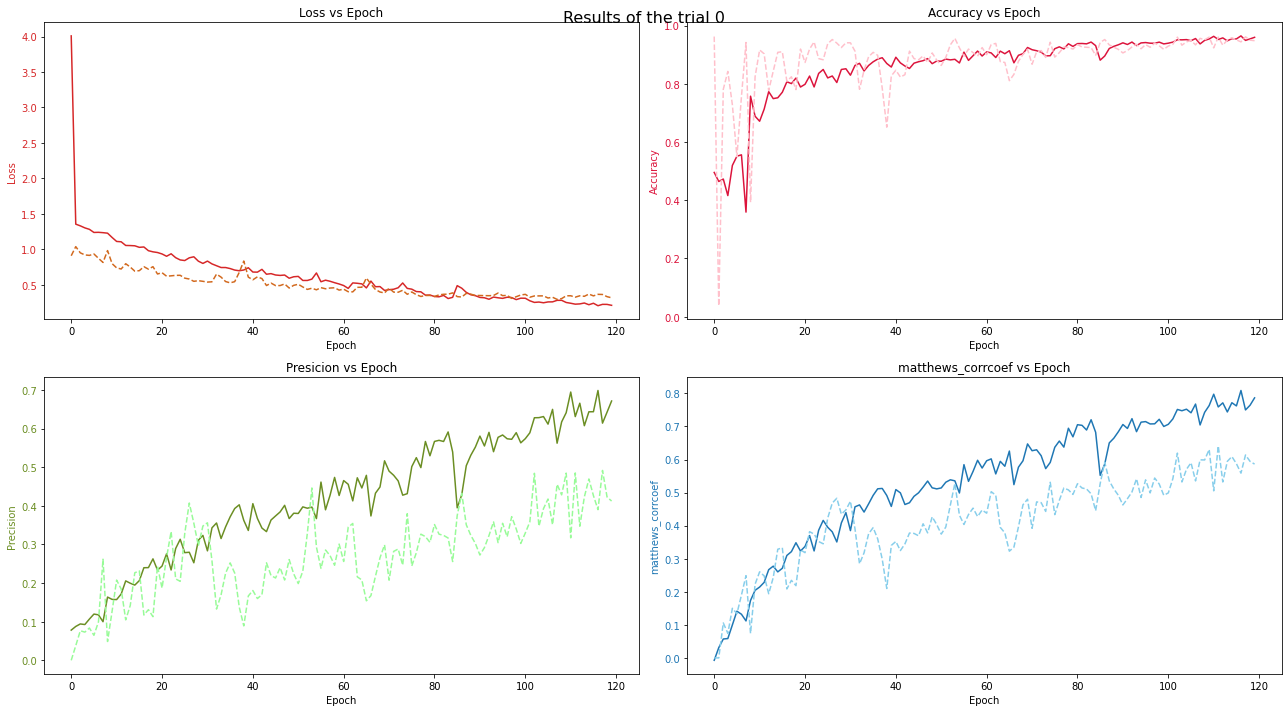

[I 2021-11-25 15:49:52,870] Trial 0 finished with value: 0.38915025654542645 and parameters: {'weight_decay': 6.854642085010894e-07, 'dropout': 0.45}. Best is trial 0 with value: 0.38915025654542645.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 4.0076 | precision_score 0.0783 | matthews_corrcoef -0.0070 | accuracy 0.4932
loss 0.9087 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9530 | precision_score 0.2322 | matthews_corrcoef 0.3196 | accuracy 0.7883
loss 0.6762 | precision_score 0.1983 | matthews_corrcoef 0.3084 | accuracy 0.8905

Epoch 40
loss 0.7051 | precision_score 0.3688 | matthews_corrcoef 0.4868 | accuracy 0.8744
loss 0.4902 | precision_score 0.3125 | matthews_corrcoef 0.4297 | accuracy 0.9314

Epoch 60
loss 0.4970 | precision_score 0.4404 | matthews_corrcoef 0.5723 | accuracy 0.9012
loss 0.4191 | precision_score 0.3500 | matthews_corrcoef 0.4883 | accuracy 0.9376

Epoch 80
loss 0.3701 | precision_score 0.4537 | matthews_corrcoef 0.6170 | accuracy 0.9044
loss 0.4487 | precision_score 0.4615 | matthews_corrcoef 0.5925 | accuracy 0.9570

Epoch 100
loss 0.2621 | precision_score 0.5599 | matthews_corrcoef 0.7053 | accuracy 0.9363
loss 0.4931 | precision_score 0.4839 |

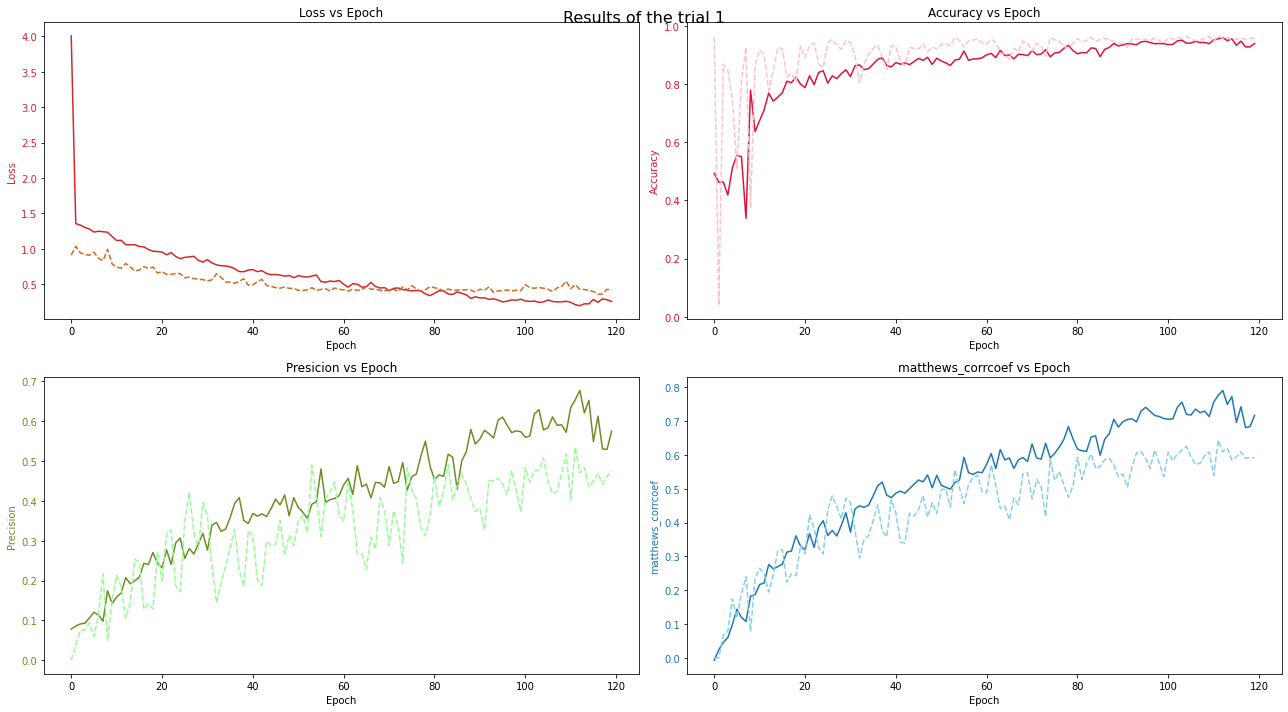

[I 2021-11-25 15:53:15,157] Trial 1 finished with value: 0.42030239469268915 and parameters: {'weight_decay': 2.3820455190468508e-05, 'dropout': 0.45}. Best is trial 1 with value: 0.42030239469268915.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 4.0076 | precision_score 0.0783 | matthews_corrcoef -0.0069 | accuracy 0.4935
loss 0.9086 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9472 | precision_score 0.2497 | matthews_corrcoef 0.3455 | accuracy 0.8026
loss 0.6920 | precision_score 0.1592 | matthews_corrcoef 0.2782 | accuracy 0.8526

Epoch 40
loss 0.7202 | precision_score 0.3648 | matthews_corrcoef 0.4731 | accuracy 0.8741
loss 0.5585 | precision_score 0.1925 | matthews_corrcoef 0.3599 | accuracy 0.8608

Epoch 60
loss 0.4958 | precision_score 0.4683 | matthews_corrcoef 0.6033 | accuracy 0.9103
loss 0.4127 | precision_score 0.2981 | matthews_corrcoef 0.4705 | accuracy 0.9191

Epoch 80
loss 0.3572 | precision_score 0.5058 | matthews_corrcoef 0.6540 | accuracy 0.9216
loss 0.3457 | precision_score 0.4444 | matthews_corrcoef 0.6008 | accuracy 0.9539

Epoch 100
loss 0.2957 | precision_score 0.5649 | matthews_corrcoef 0.7037 | accuracy 0.9373
loss 0.3419 | precision_score 0.4507 |

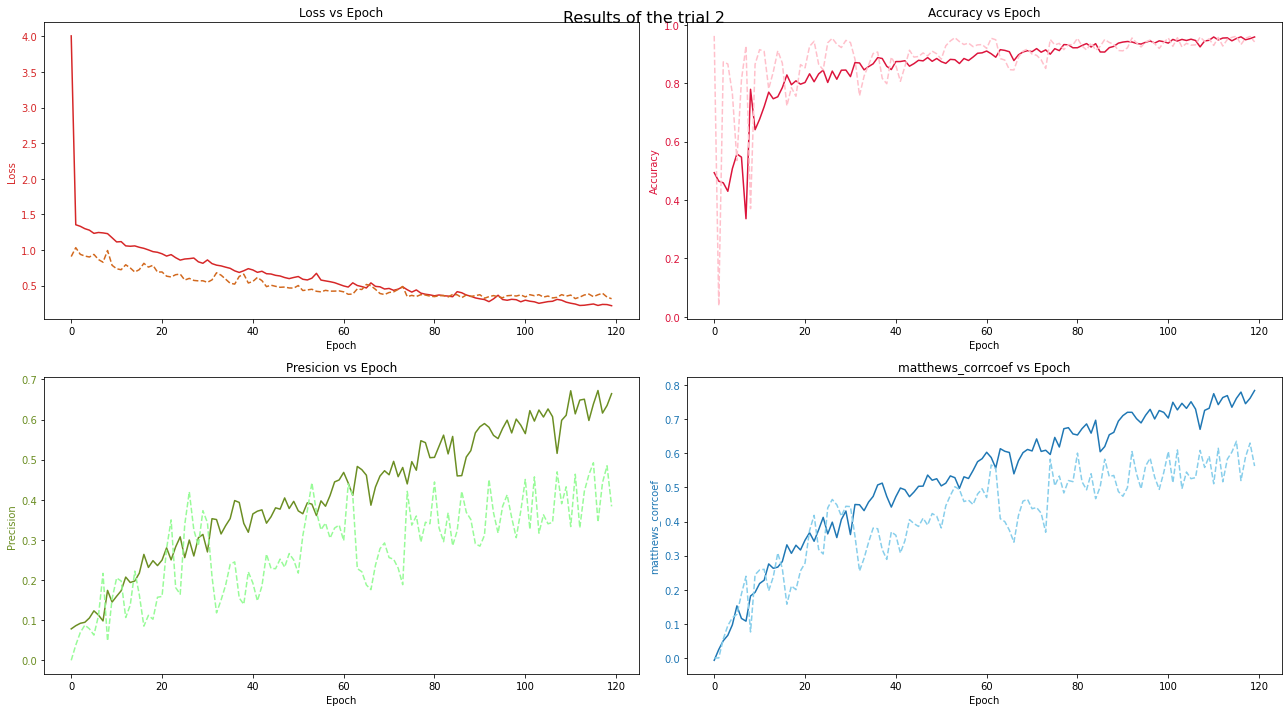

[I 2021-11-25 15:56:37,529] Trial 2 finished with value: 0.38554203789362 and parameters: {'weight_decay': 2.1181497672408895e-05, 'dropout': 0.45}. Best is trial 1 with value: 0.42030239469268915.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 3.6094 | precision_score 0.0749 | matthews_corrcoef -0.0199 | accuracy 0.4817
loss 0.9048 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9488 | precision_score 0.2584 | matthews_corrcoef 0.3475 | accuracy 0.8141
loss 0.7376 | precision_score 0.1233 | matthews_corrcoef 0.2405 | accuracy 0.7932

Epoch 40
loss 0.7372 | precision_score 0.3575 | matthews_corrcoef 0.4666 | accuracy 0.8707
loss 0.6345 | precision_score 0.1397 | matthews_corrcoef 0.2953 | accuracy 0.7932

Epoch 60
loss 0.5800 | precision_score 0.4179 | matthews_corrcoef 0.5465 | accuracy 0.8933
loss 0.4956 | precision_score 0.2075 | matthews_corrcoef 0.3919 | accuracy 0.8669

Epoch 80
loss 0.4852 | precision_score 0.4395 | matthews_corrcoef 0.5788 | accuracy 0.9004
loss 0.4287 | precision_score 0.2857 | matthews_corrcoef 0.4672 | accuracy 0.9130

Epoch 100
loss 0.3653 | precision_score 0.5496 | matthews_corrcoef 0.6794 | accuracy 0.9331
loss 0.4346 | precision_score 0.2462 |

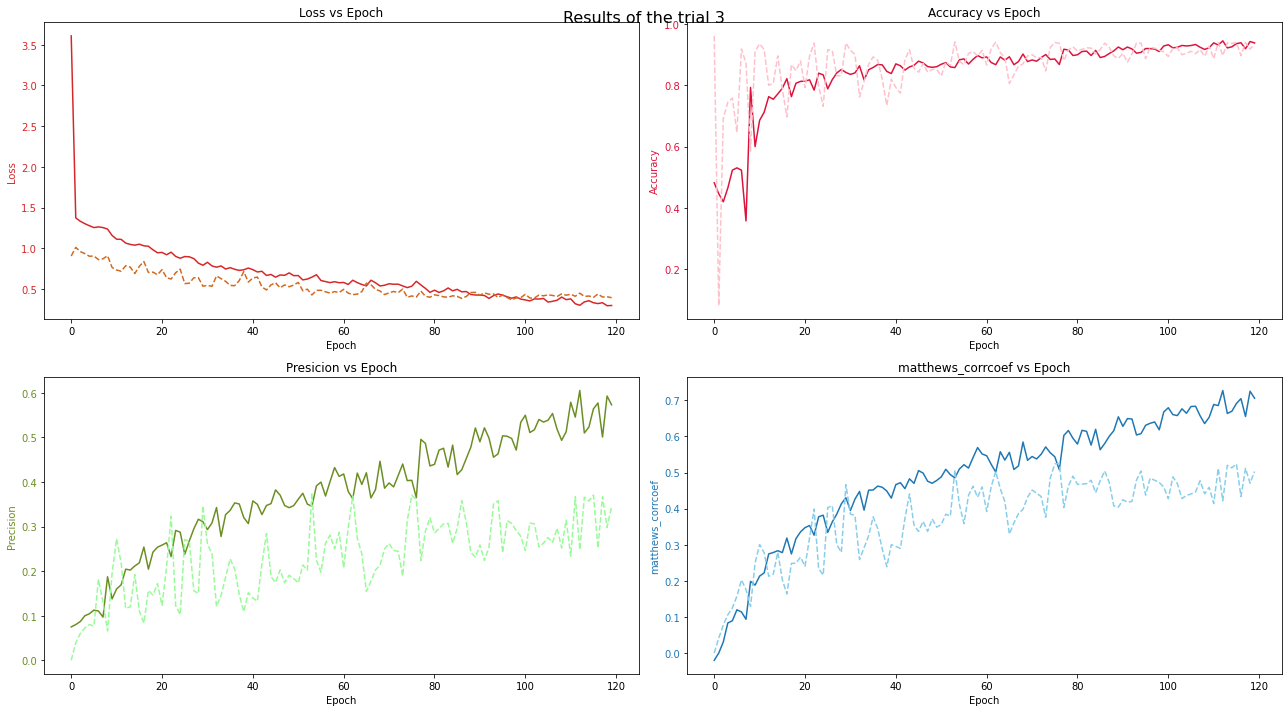

[I 2021-11-25 16:00:01,023] Trial 3 finished with value: 0.2983243911622532 and parameters: {'weight_decay': 1.2367929302904035e-07, 'dropout': 0.55}. Best is trial 1 with value: 0.42030239469268915.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 3.9324 | precision_score 0.0771 | matthews_corrcoef -0.0117 | accuracy 0.4750
loss 0.9072 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9532 | precision_score 0.2533 | matthews_corrcoef 0.3400 | accuracy 0.8107
loss 0.6994 | precision_score 0.1603 | matthews_corrcoef 0.2795 | accuracy 0.8536

Epoch 40
loss 0.7071 | precision_score 0.3662 | matthews_corrcoef 0.4845 | accuracy 0.8731
loss 0.5753 | precision_score 0.1576 | matthews_corrcoef 0.3022 | accuracy 0.8332

Epoch 60
loss 0.5328 | precision_score 0.4639 | matthews_corrcoef 0.5850 | accuracy 0.9093
loss 0.4785 | precision_score 0.2129 | matthews_corrcoef 0.3982 | accuracy 0.8710

Epoch 80
loss 0.4189 | precision_score 0.4724 | matthews_corrcoef 0.6214 | accuracy 0.9112
loss 0.4071 | precision_score 0.3750 | matthews_corrcoef 0.5274 | accuracy 0.9417

Epoch 100
loss 0.2844 | precision_score 0.5854 | matthews_corrcoef 0.7226 | accuracy 0.9422
loss 0.4367 | precision_score 0.3571 |

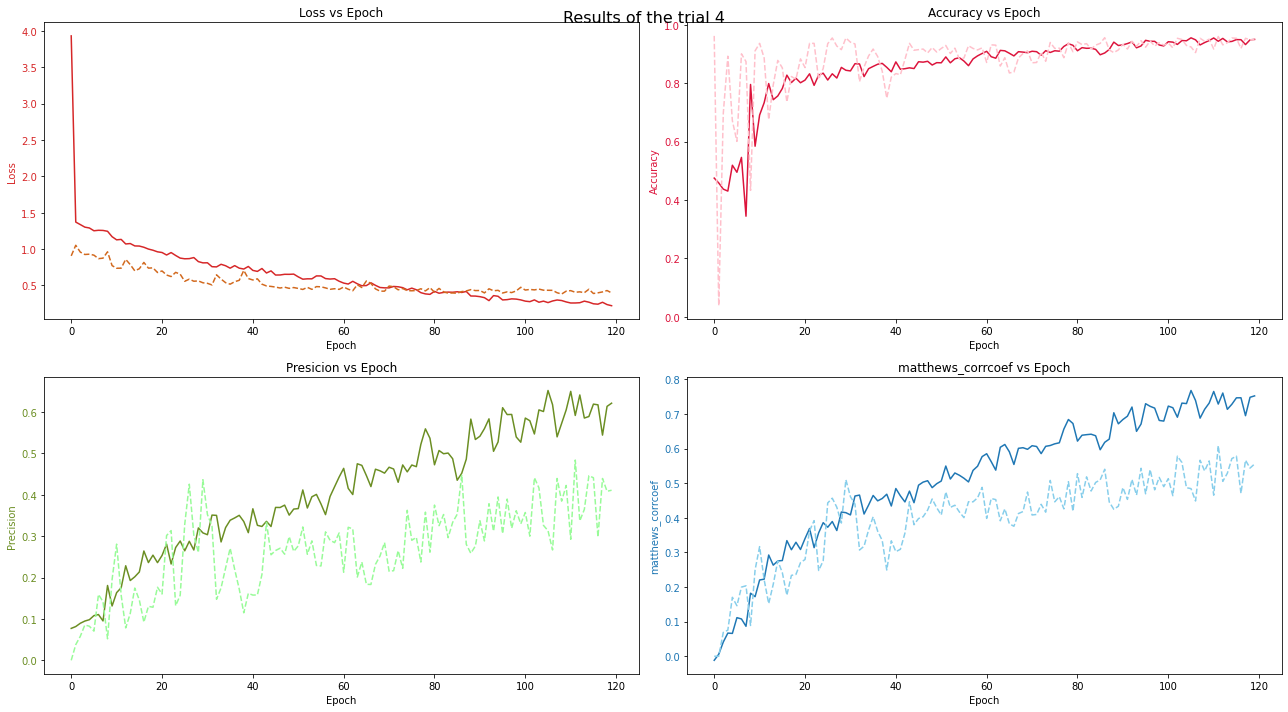

[I 2021-11-25 16:03:23,859] Trial 4 finished with value: 0.35296370918898606 and parameters: {'weight_decay': 7.423841377449822e-06, 'dropout': 0.5}. Best is trial 1 with value: 0.42030239469268915.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 4.0076 | precision_score 0.0783 | matthews_corrcoef -0.0069 | accuracy 0.4935
loss 0.9086 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9481 | precision_score 0.2451 | matthews_corrcoef 0.3392 | accuracy 0.7986
loss 0.6980 | precision_score 0.1534 | matthews_corrcoef 0.2708 | accuracy 0.8465

Epoch 40
loss 0.6876 | precision_score 0.3903 | matthews_corrcoef 0.5032 | accuracy 0.8842
loss 0.5795 | precision_score 0.1796 | matthews_corrcoef 0.3372 | accuracy 0.8526

Epoch 60
loss 0.5096 | precision_score 0.4672 | matthews_corrcoef 0.5988 | accuracy 0.9100
loss 0.4396 | precision_score 0.2755 | matthews_corrcoef 0.4157 | accuracy 0.9171

Epoch 80
loss 0.3704 | precision_score 0.4960 | matthews_corrcoef 0.6501 | accuracy 0.9186
loss 0.3761 | precision_score 0.4091 | matthews_corrcoef 0.5234 | accuracy 0.9498

Epoch 100
loss 0.3141 | precision_score 0.5345 | matthews_corrcoef 0.6824 | accuracy 0.9297
loss 0.4037 | precision_score 0.4306 |

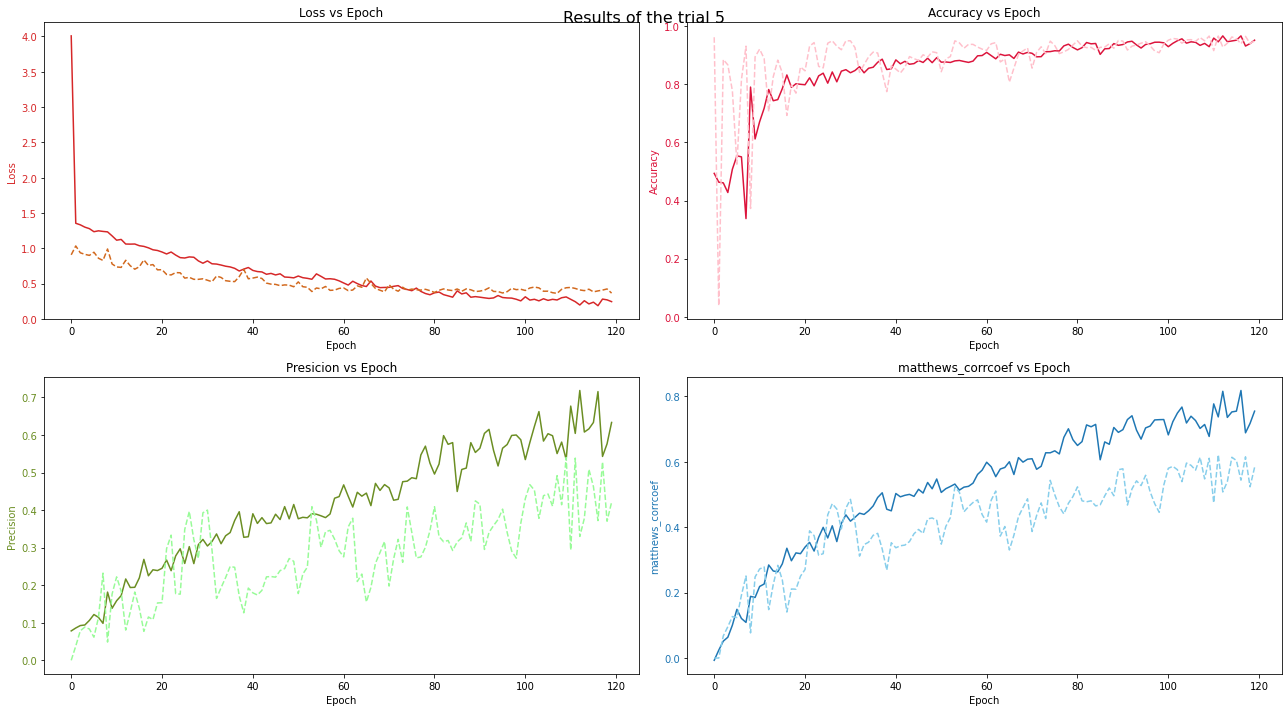

[I 2021-11-25 16:06:47,165] Trial 5 finished with value: 0.37838026699175703 and parameters: {'weight_decay': 2.111602003597942e-05, 'dropout': 0.45}. Best is trial 1 with value: 0.42030239469268915.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 4.0081 | precision_score 0.0779 | matthews_corrcoef -0.0083 | accuracy 0.4937
loss 0.9092 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9477 | precision_score 0.2459 | matthews_corrcoef 0.3420 | accuracy 0.7984
loss 0.6973 | precision_score 0.1486 | matthews_corrcoef 0.2709 | accuracy 0.8362

Epoch 40
loss 0.6985 | precision_score 0.3867 | matthews_corrcoef 0.4978 | accuracy 0.8830
loss 0.5647 | precision_score 0.1714 | matthews_corrcoef 0.3268 | accuracy 0.8444

Epoch 60
loss 0.5264 | precision_score 0.4389 | matthews_corrcoef 0.5747 | accuracy 0.9004
loss 0.4298 | precision_score 0.2970 | matthews_corrcoef 0.4610 | accuracy 0.9202

Epoch 80
loss 0.3830 | precision_score 0.4730 | matthews_corrcoef 0.6292 | accuracy 0.9112
loss 0.4141 | precision_score 0.4328 | matthews_corrcoef 0.5614 | accuracy 0.9529

Epoch 100
loss 0.2536 | precision_score 0.5913 | matthews_corrcoef 0.7295 | accuracy 0.9437
loss 0.4372 | precision_score 0.4412 |

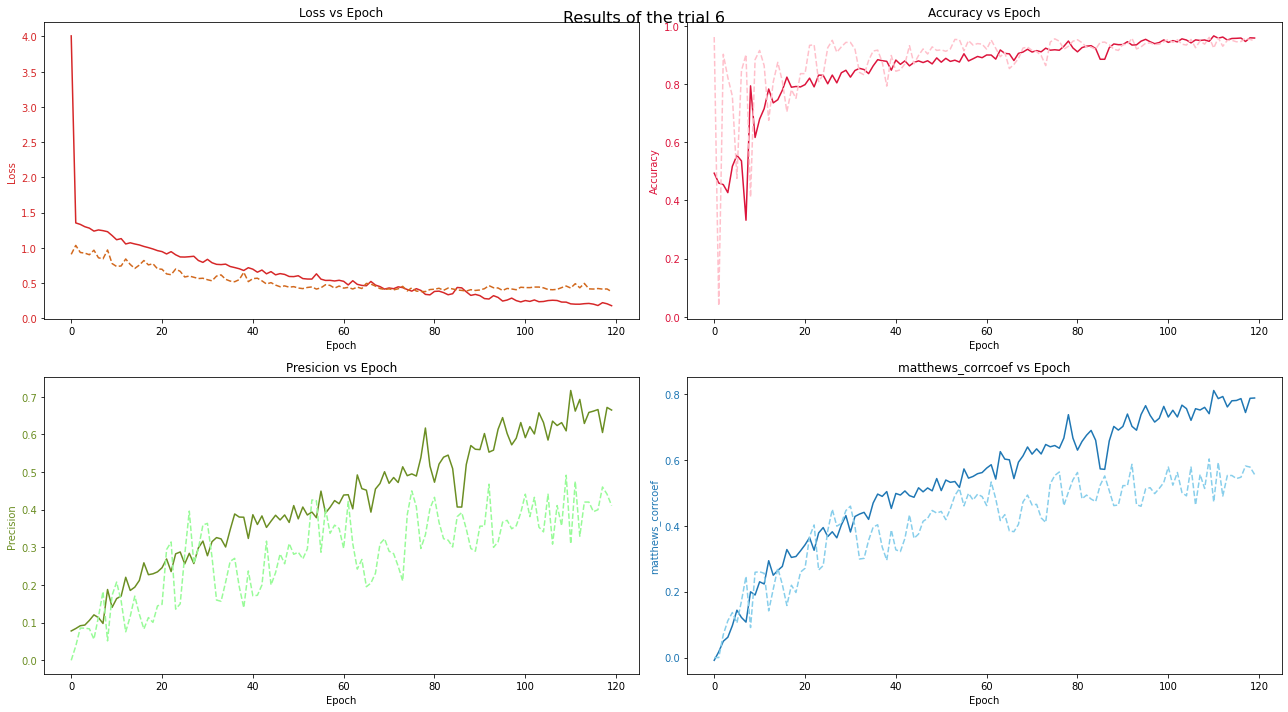

[I 2021-11-25 16:10:10,049] Trial 6 finished with value: 0.34874480636165195 and parameters: {'weight_decay': 6.754404569301113e-06, 'dropout': 0.45}. Best is trial 1 with value: 0.42030239469268915.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 3.9346 | precision_score 0.0776 | matthews_corrcoef -0.0098 | accuracy 0.4782
loss 0.9080 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9557 | precision_score 0.2511 | matthews_corrcoef 0.3375 | accuracy 0.8087
loss 0.6741 | precision_score 0.1984 | matthews_corrcoef 0.3236 | accuracy 0.8843

Epoch 40
loss 0.7022 | precision_score 0.3820 | matthews_corrcoef 0.4972 | accuracy 0.8805
loss 0.5589 | precision_score 0.1893 | matthews_corrcoef 0.3629 | accuracy 0.8547

Epoch 60
loss 0.5276 | precision_score 0.4467 | matthews_corrcoef 0.5775 | accuracy 0.9034
loss 0.4599 | precision_score 0.2459 | matthews_corrcoef 0.4117 | accuracy 0.8987

Epoch 80
loss 0.3924 | precision_score 0.4855 | matthews_corrcoef 0.6331 | accuracy 0.9154
loss 0.3978 | precision_score 0.4384 | matthews_corrcoef 0.5962 | accuracy 0.9529

Epoch 100
loss 0.3381 | precision_score 0.5168 | matthews_corrcoef 0.6663 | accuracy 0.9248
loss 0.3657 | precision_score 0.3951 |

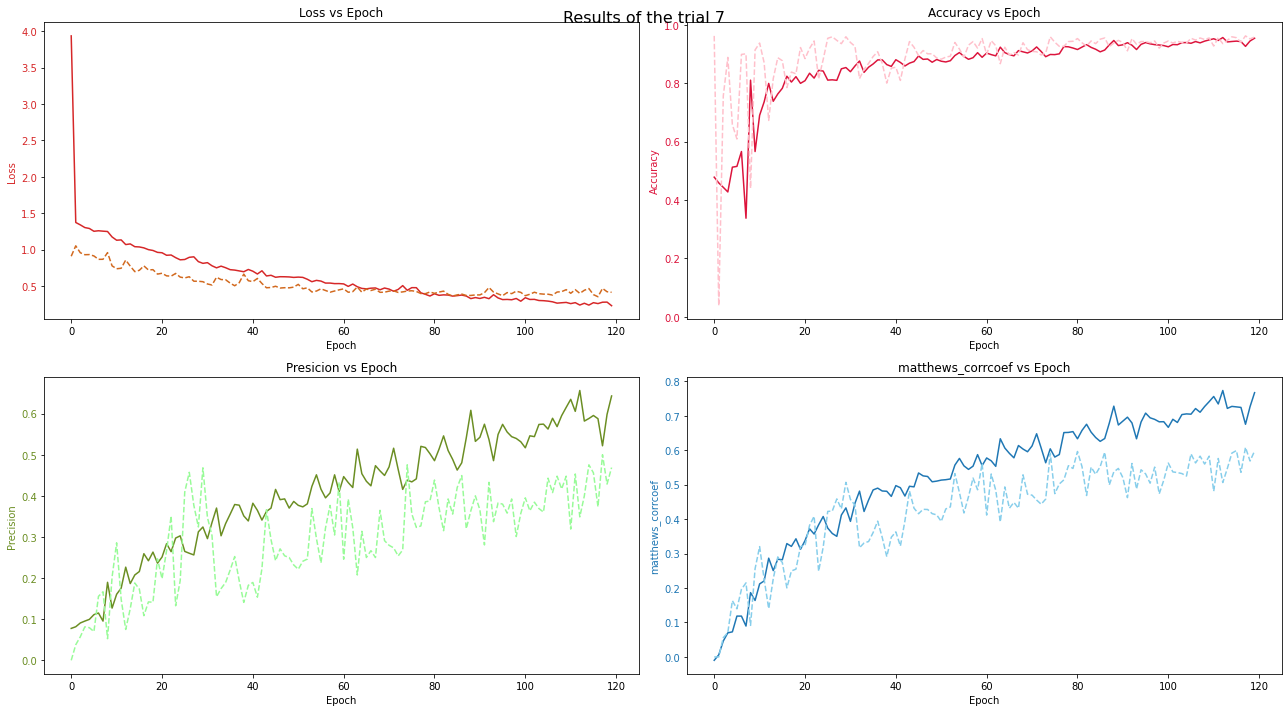

[I 2021-11-25 16:13:31,136] Trial 7 finished with value: 0.38213190186193596 and parameters: {'weight_decay': 4.924243226792427e-07, 'dropout': 0.5}. Best is trial 1 with value: 0.42030239469268915.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 4.0079 | precision_score 0.0783 | matthews_corrcoef -0.0068 | accuracy 0.4962
loss 0.9095 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9480 | precision_score 0.2459 | matthews_corrcoef 0.3430 | accuracy 0.7979
loss 0.6942 | precision_score 0.1553 | matthews_corrcoef 0.2732 | accuracy 0.8485

Epoch 40
loss 0.6850 | precision_score 0.3764 | matthews_corrcoef 0.4958 | accuracy 0.8776
loss 0.5154 | precision_score 0.2168 | matthews_corrcoef 0.3881 | accuracy 0.8792

Epoch 60
loss 0.5505 | precision_score 0.4399 | matthews_corrcoef 0.5731 | accuracy 0.9009
loss 0.4207 | precision_score 0.3152 | matthews_corrcoef 0.4685 | accuracy 0.9273

Epoch 80
loss 0.3836 | precision_score 0.4935 | matthews_corrcoef 0.6406 | accuracy 0.9179
loss 0.3952 | precision_score 0.3889 | matthews_corrcoef 0.5187 | accuracy 0.9458

Epoch 100
loss 0.2960 | precision_score 0.5456 | matthews_corrcoef 0.6921 | accuracy 0.9326
loss 0.3951 | precision_score 0.4328 |

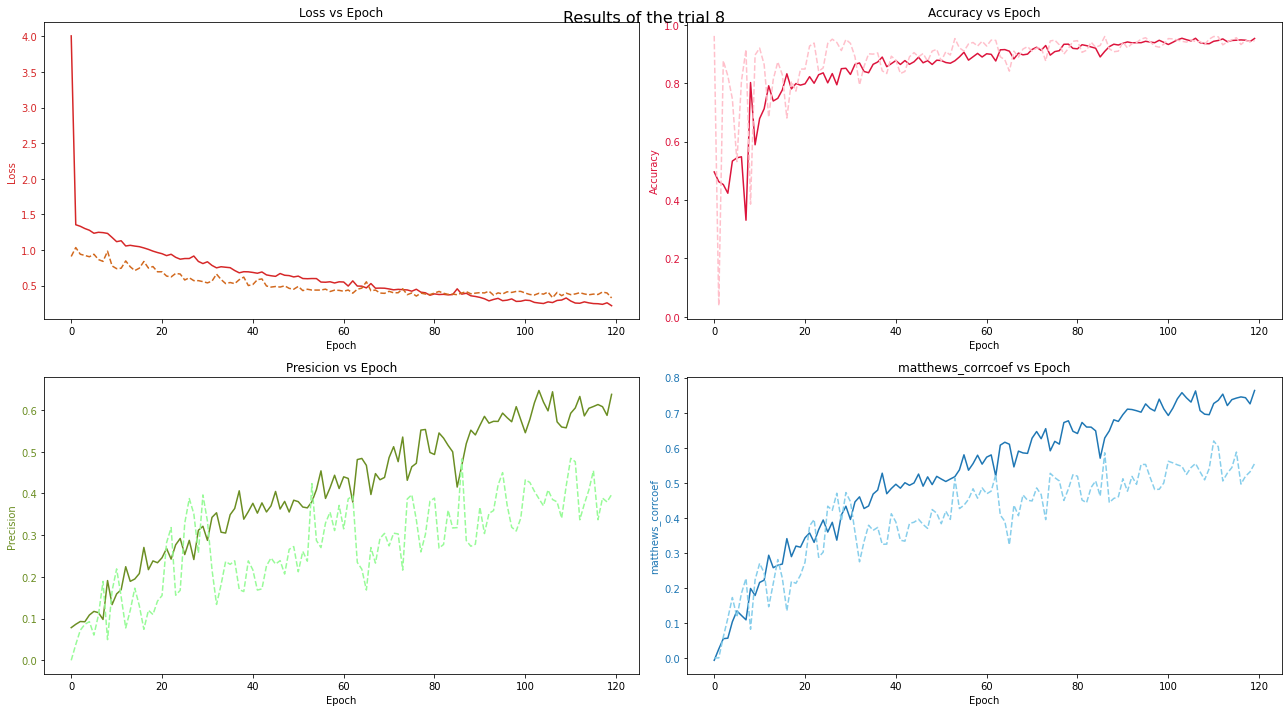

[I 2021-11-25 16:16:51,145] Trial 8 finished with value: 0.3720362109466008 and parameters: {'weight_decay': 8.649009921942377e-06, 'dropout': 0.45}. Best is trial 1 with value: 0.42030239469268915.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 3.9347 | precision_score 0.0775 | matthews_corrcoef -0.0101 | accuracy 0.4777
loss 0.9081 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9436 | precision_score 0.2547 | matthews_corrcoef 0.3425 | accuracy 0.8114
loss 0.6973 | precision_score 0.1484 | matthews_corrcoef 0.2769 | accuracy 0.8311

Epoch 40
loss 0.6961 | precision_score 0.3910 | matthews_corrcoef 0.5061 | accuracy 0.8842
loss 0.5414 | precision_score 0.1886 | matthews_corrcoef 0.3688 | accuracy 0.8506

Epoch 60
loss 0.5452 | precision_score 0.4506 | matthews_corrcoef 0.5769 | accuracy 0.9048
loss 0.4587 | precision_score 0.2589 | matthews_corrcoef 0.4167 | accuracy 0.9069

Epoch 80
loss 0.4022 | precision_score 0.4518 | matthews_corrcoef 0.6046 | accuracy 0.9041
loss 0.3984 | precision_score 0.4000 | matthews_corrcoef 0.5270 | accuracy 0.9478

Epoch 100
loss 0.3213 | precision_score 0.5193 | matthews_corrcoef 0.6695 | accuracy 0.9255
loss 0.4097 | precision_score 0.4143 |

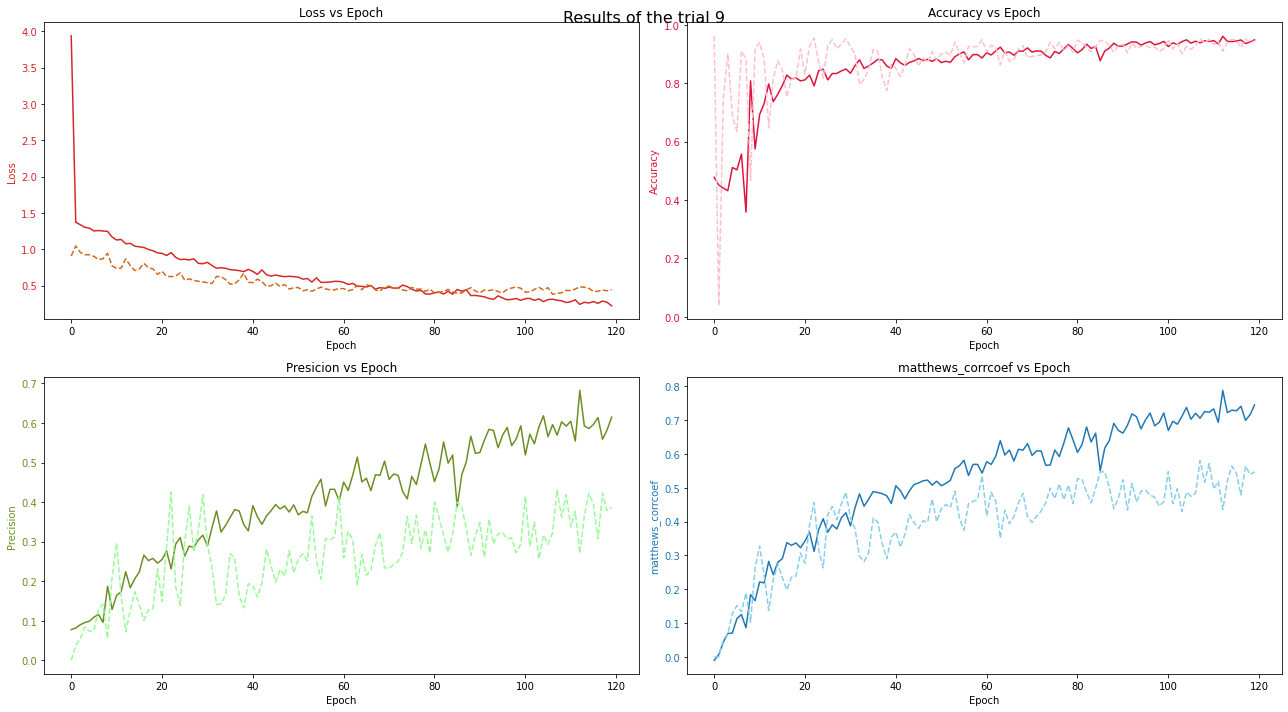

[I 2021-11-25 16:20:09,230] Trial 9 finished with value: 0.3215449265477527 and parameters: {'weight_decay': 1.0653397116169406e-06, 'dropout': 0.5}. Best is trial 1 with value: 0.42030239469268915.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 3.6084 | precision_score 0.0751 | matthews_corrcoef -0.0192 | accuracy 0.4805
loss 0.9035 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9591 | precision_score 0.2542 | matthews_corrcoef 0.3419 | accuracy 0.8109
loss 0.7057 | precision_score 0.1465 | matthews_corrcoef 0.2490 | accuracy 0.8485

Epoch 40
loss 0.7973 | precision_score 0.3065 | matthews_corrcoef 0.4227 | accuracy 0.8407
loss 0.5778 | precision_score 0.1714 | matthews_corrcoef 0.3268 | accuracy 0.8444

Epoch 60
loss 0.6251 | precision_score 0.4081 | matthews_corrcoef 0.5335 | accuracy 0.8898
loss 0.5178 | precision_score 0.1890 | matthews_corrcoef 0.3557 | accuracy 0.8577

Epoch 80
loss 0.4668 | precision_score 0.4602 | matthews_corrcoef 0.6054 | accuracy 0.9073
loss 0.4271 | precision_score 0.2913 | matthews_corrcoef 0.4557 | accuracy 0.9181

Epoch 100
loss 0.3538 | precision_score 0.5008 | matthews_corrcoef 0.6601 | accuracy 0.9201
loss 0.4446 | precision_score 0.2752 |

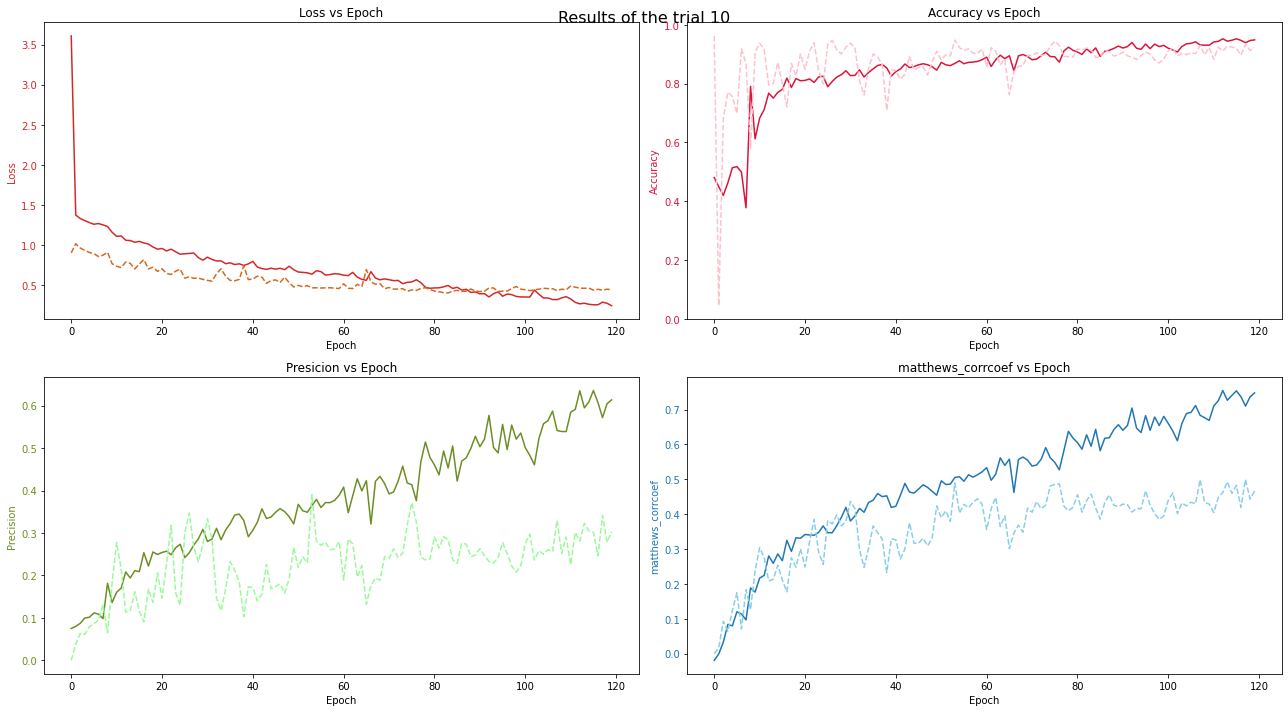

[I 2021-11-25 16:23:26,940] Trial 10 finished with value: 0.24457766373348183 and parameters: {'weight_decay': 7.48131642167171e-05, 'dropout': 0.55}. Best is trial 1 with value: 0.42030239469268915.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 4.0085 | precision_score 0.0783 | matthews_corrcoef -0.0069 | accuracy 0.4935
loss 0.9096 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9446 | precision_score 0.2411 | matthews_corrcoef 0.3346 | accuracy 0.7947
loss 0.6727 | precision_score 0.1857 | matthews_corrcoef 0.3168 | accuracy 0.8721

Epoch 40
loss 0.7137 | precision_score 0.3693 | matthews_corrcoef 0.4838 | accuracy 0.8751
loss 0.5722 | precision_score 0.1714 | matthews_corrcoef 0.3268 | accuracy 0.8444

Epoch 60
loss 0.5047 | precision_score 0.4806 | matthews_corrcoef 0.6093 | accuracy 0.9142
loss 0.4230 | precision_score 0.2735 | matthews_corrcoef 0.4553 | accuracy 0.9079

Epoch 80
loss 0.3458 | precision_score 0.5339 | matthews_corrcoef 0.6781 | accuracy 0.9294
loss 0.3688 | precision_score 0.3797 | matthews_corrcoef 0.5312 | accuracy 0.9427

Epoch 100
loss 0.2651 | precision_score 0.5962 | matthews_corrcoef 0.7276 | accuracy 0.9444
loss 0.3516 | precision_score 0.4688 |

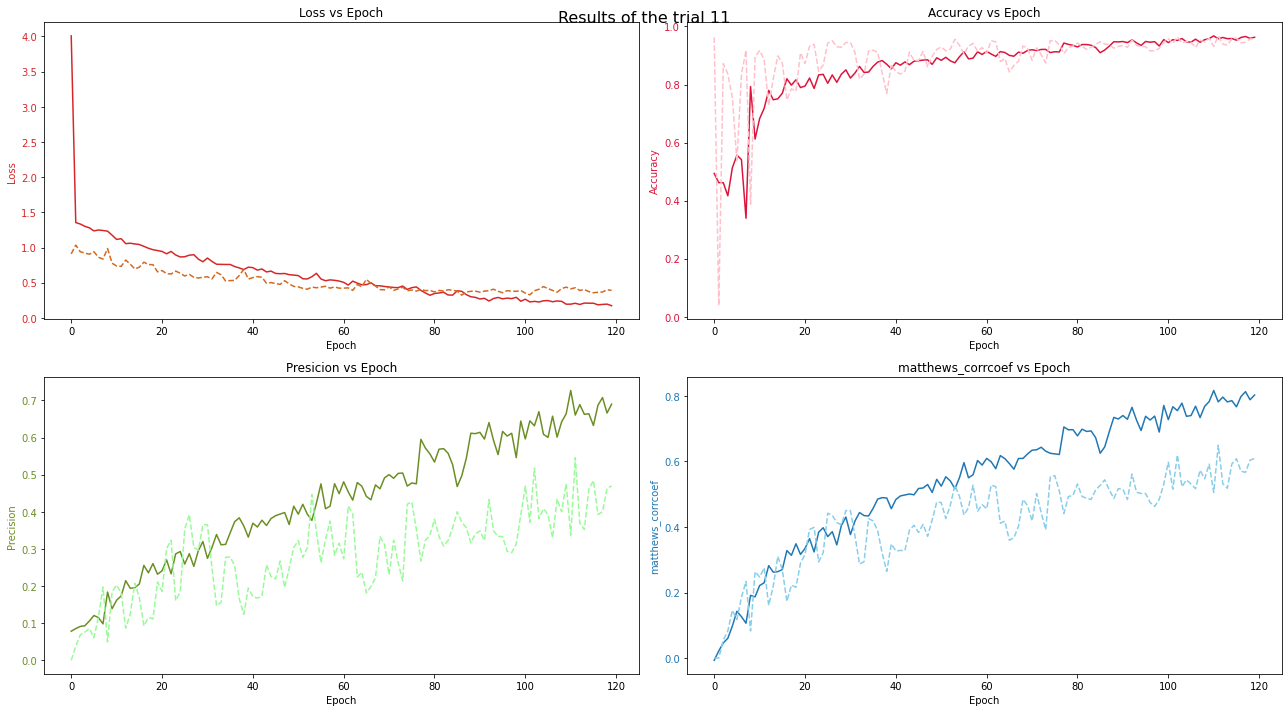

[I 2021-11-25 16:26:45,108] Trial 11 finished with value: 0.379405751470583 and parameters: {'weight_decay': 1.0895253032704285e-06, 'dropout': 0.45}. Best is trial 1 with value: 0.42030239469268915.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 4.0108 | precision_score 0.0781 | matthews_corrcoef -0.0077 | accuracy 0.4947
loss 0.9096 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9342 | precision_score 0.2404 | matthews_corrcoef 0.3282 | accuracy 0.7971
loss 0.6759 | precision_score 0.1745 | matthews_corrcoef 0.3036 | accuracy 0.8628

Epoch 40
loss 0.6597 | precision_score 0.4065 | matthews_corrcoef 0.5204 | accuracy 0.8903
loss 0.5395 | precision_score 0.1953 | matthews_corrcoef 0.3771 | accuracy 0.8567

Epoch 60
loss 0.4494 | precision_score 0.4916 | matthews_corrcoef 0.6266 | accuracy 0.9174
loss 0.4139 | precision_score 0.2750 | matthews_corrcoef 0.4649 | accuracy 0.9069

Epoch 80
loss 0.3779 | precision_score 0.5316 | matthews_corrcoef 0.6596 | accuracy 0.9284
loss 0.4012 | precision_score 0.3131 | matthews_corrcoef 0.4842 | accuracy 0.9243

Epoch 100
loss 0.2989 | precision_score 0.5749 | matthews_corrcoef 0.7084 | accuracy 0.9395
loss 0.3718 | precision_score 0.4286 |

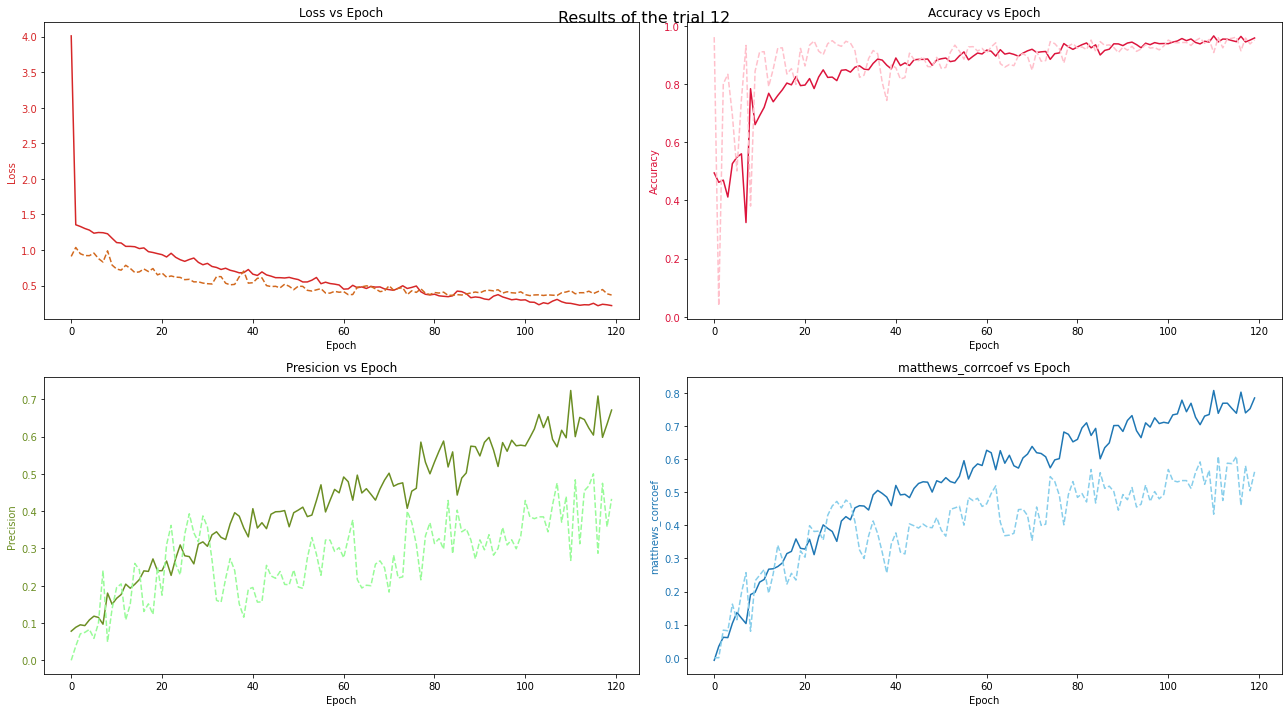

[I 2021-11-25 16:30:04,301] Trial 12 finished with value: 0.36114810147557835 and parameters: {'weight_decay': 2.712636585747467e-07, 'dropout': 0.45}. Best is trial 1 with value: 0.42030239469268915.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 3.9346 | precision_score 0.0775 | matthews_corrcoef -0.0104 | accuracy 0.4773
loss 0.9079 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9442 | precision_score 0.2446 | matthews_corrcoef 0.3283 | accuracy 0.8038
loss 0.6861 | precision_score 0.1579 | matthews_corrcoef 0.2896 | accuracy 0.8424

Epoch 40
loss 0.7150 | precision_score 0.3978 | matthews_corrcoef 0.5060 | accuracy 0.8876
loss 0.5674 | precision_score 0.1939 | matthews_corrcoef 0.3686 | accuracy 0.8588

Epoch 60
loss 0.5303 | precision_score 0.4607 | matthews_corrcoef 0.5886 | accuracy 0.9080
loss 0.4480 | precision_score 0.2736 | matthews_corrcoef 0.4308 | accuracy 0.9130

Epoch 80
loss 0.3831 | precision_score 0.5000 | matthews_corrcoef 0.6482 | accuracy 0.9198
loss 0.3965 | precision_score 0.4054 | matthews_corrcoef 0.5512 | accuracy 0.9478

Epoch 100
loss 0.3087 | precision_score 0.5538 | matthews_corrcoef 0.6955 | accuracy 0.9346
loss 0.3990 | precision_score 0.3229 |

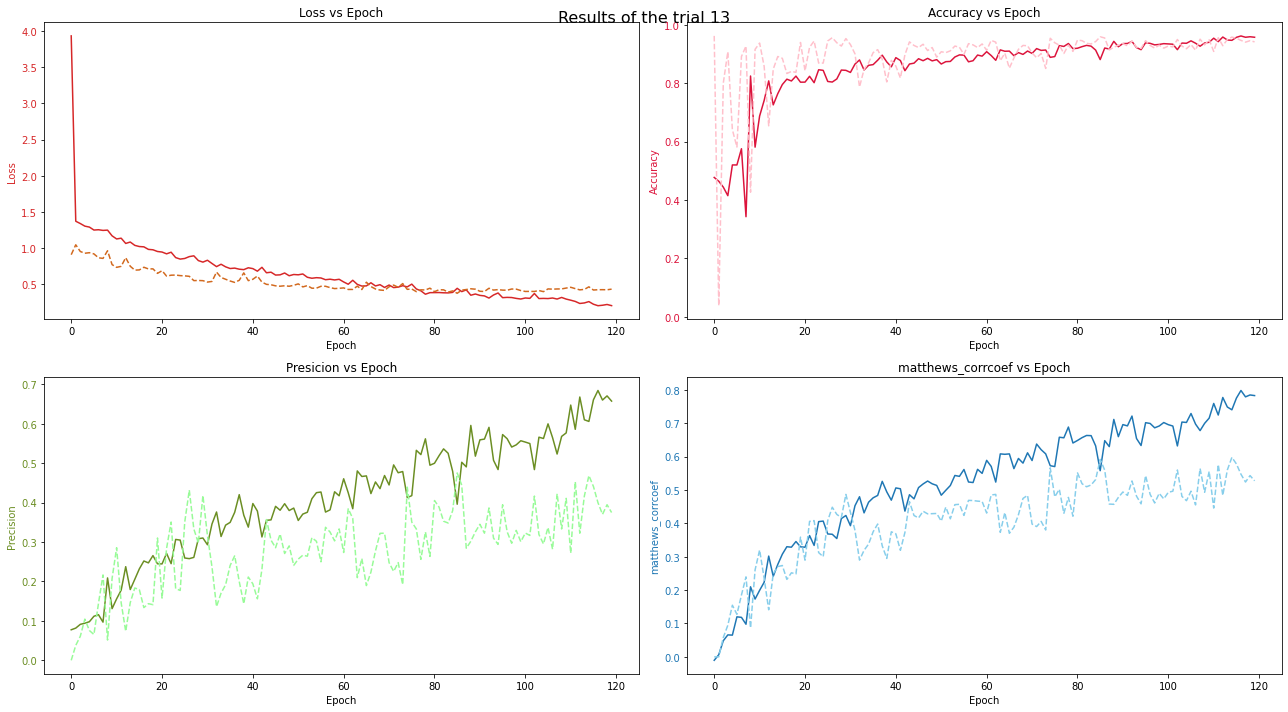

[I 2021-11-25 16:33:24,525] Trial 13 finished with value: 0.3414289693524154 and parameters: {'weight_decay': 1.3204701733456678e-06, 'dropout': 0.5}. Best is trial 1 with value: 0.42030239469268915.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 4.0082 | precision_score 0.0780 | matthews_corrcoef -0.0080 | accuracy 0.4942
loss 0.9092 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9549 | precision_score 0.2384 | matthews_corrcoef 0.3305 | accuracy 0.7925
loss 0.6985 | precision_score 0.1613 | matthews_corrcoef 0.2808 | accuracy 0.8547

Epoch 40
loss 0.6937 | precision_score 0.4012 | matthews_corrcoef 0.5124 | accuracy 0.8886
loss 0.5742 | precision_score 0.1925 | matthews_corrcoef 0.3599 | accuracy 0.8608

Epoch 60
loss 0.5441 | precision_score 0.4176 | matthews_corrcoef 0.5569 | accuracy 0.8923
loss 0.4035 | precision_score 0.3605 | matthews_corrcoef 0.5250 | accuracy 0.9376

Epoch 80
loss 0.4077 | precision_score 0.4855 | matthews_corrcoef 0.6331 | accuracy 0.9154
loss 0.3635 | precision_score 0.3523 | matthews_corrcoef 0.5182 | accuracy 0.9355

Epoch 100
loss 0.3122 | precision_score 0.5813 | matthews_corrcoef 0.7089 | accuracy 0.9407
loss 0.3963 | precision_score 0.3810 |

KeyboardInterrupt: ignored

In [12]:
def objective_fp(trial):
    print('Test dataset: \n')
    batch_size_test = 150
    root = '/content/drive/MyDrive/GNN/testing'
    test_file_name = '/content/drive/MyDrive/ampc_fp_optuna/test_ds_mk.csv' 
    test_dataloader, _ = get_dataset_and_weight(
        root, test_file_name, batch_size_test, shuffle=False)

    # OPTUNA
    print('Train dataset: \n')
    batch_size_train = 500 #trial.suggest_int('batch_size', 411, 511, step=100)
    root = '/content/drive/MyDrive/GNN/training'
    train_file_name = '/content/drive/MyDrive/ampc_fp_optuna/training_ds_mk.csv' 
    model, criterion, optimizer, train_dataloader = get_all_optuna(trial, root, train_file_name, batch_size_train, shuffle=True)
    
    # Generate the model.
    model = model.to(DEVICE)
    criterion = criterion.to(DEVICE)

    # Training init
    EPOCHS = 120
    test_precision_score_mean, metrics = training_init(EPOCHS, model, [train_dataloader,
                  test_dataloader], criterion, optimizer)

    # Metrics unpacking
    train_metrics, test_metrics = metrics
    train_metrics, test_metrics = np.array(train_metrics), np.array(test_metrics)

    train_total_loss, train_precision_score, train_matthews_corrcoef, train_accuracy = train_metrics[:,0], train_metrics[:,1], train_metrics[:,2], train_metrics[:,3]
    test_total_loss, test_precision_score, test_matthews_corrcoef, test_accuracy = test_metrics[:,0], test_metrics[:,1], test_metrics[:,2], test_metrics[:,3]

    # Taken from matplotlib documentation
    # Taken from matplotlib documentation
    fig, ax1 = plt.subplots(2, 2, figsize=(18,10))
    fig.suptitle(f'Results of the trial {trial.number}', fontsize=16)
    t = range(EPOCHS)


    # Loss
    ax1[0, 0].set_title('Loss vs Epoch')
    ax1[0, 0].set_xlabel('Epoch')
    ax1[0, 0].set_ylabel('Loss', color='tab:red')
    ax1[0, 0].tick_params(axis='y', labelcolor='tab:red')
    ax1[0, 0].plot(t, train_total_loss, color='tab:red')
    ax1[0, 0].plot(t, test_total_loss, color='chocolate', linestyle='dashed')

    # Presicion
    ax1[1, 0].set_title('Presicion vs Epoch')
    ax1[1, 0].set_xlabel('Epoch')
    ax1[1, 0].set_ylabel('Precision', color='olivedrab')  
    ax1[1, 0].tick_params(axis='y', labelcolor='olivedrab')

    ax1[1, 0].plot(t, train_precision_score, color='olivedrab')
    ax1[1, 0].plot(t, test_precision_score, color='palegreen', linestyle='dashed')

    # matthews_corrcoef
    ax1[1, 1].set_title('matthews_corrcoef vs Epoch')
    ax1[1, 1].set_xlabel('Epoch')
    ax1[1, 1].set_ylabel('matthews_corrcoef', color='tab:blue')  
    ax1[1, 1].tick_params(axis='y', labelcolor='tab:blue')

    ax1[1, 1].plot(t, train_matthews_corrcoef, color='tab:blue')
    ax1[1, 1].plot(t, test_matthews_corrcoef, color='skyblue', linestyle='dashed')

    # Accuracy
    ax1[0, 1].set_title('Accuracy vs Epoch')
    ax1[0, 1].set_ylabel('Accuracy', color='crimson')  
    ax1[0, 1].set_xlabel('Epoch')
    ax1[0, 1].tick_params(axis='y', labelcolor='crimson')

    ax1[0, 1].plot(t, train_accuracy, color='crimson')
    ax1[0, 1].plot(t, test_accuracy, color='pink', linestyle='dashed')

    fig.tight_layout() 
    plt.show()

    # Training of the model.
    return test_precision_score_mean + (mean(train_total_loss[-5:]) - mean(test_total_loss[-5:]))/4 # An idea to optimize presicion and avoide overfitting


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_fp, n_trials=20, timeout=None)

    pruned_trials = study.get_trials(
        deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(
        deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))



In [ ]:
# Optimización general de la presición usando todos los parámetros siguientes:'batch_size', 'lr', 'weight_decay', 'num_layers', 'hidden_channels', 'dropout'
# Optimización del Loss usando dropout y weigth decay, usando los mejores parámetros encontrados en el paso anterior: batch_size:500, lr:0.0015294022249668856, weight_decay: 3.7540522058417304e-06, num_layers:2, hidden_chanes:320
# I get the idea to use loss in te obj function to try to optimize both presicion an loss dif between train loss and test loss (to avoide overfitting)
# After that big wd or dropout make very unstable the training, making all metrics fluctuate very hard. So lower limmit where stablish

La optimización usando costo y presición falló. Pienso que se debe a que existe mucha diferencia entre train loss y test loss a comparación del valor de precisión. Así que optuna está dando prioridad a el loss.

In [13]:
study.best_trials

[FrozenTrial(number=1, values=[0.42030239469268915], datetime_start=datetime.datetime(2021, 11, 25, 15, 49, 52, 884084), datetime_complete=datetime.datetime(2021, 11, 25, 15, 53, 15, 157251), params={'weight_decay': 2.3820455190468508e-05, 'dropout': 0.45}, distributions={'weight_decay': LogUniformDistribution(high=0.0001, low=1e-07), 'dropout': DiscreteUniformDistribution(high=0.55, low=0.45, q=0.05)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=1, state=TrialState.COMPLETE, value=None)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



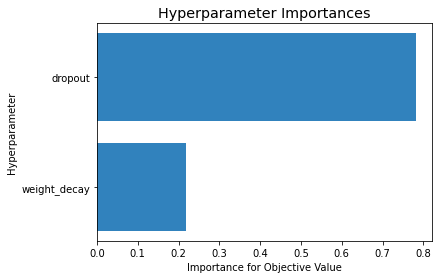

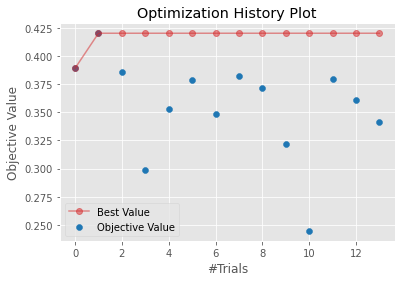

In [14]:
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(study);
plot_optimization_history(study);

---

## Savinf the model

In [18]:
PATH = '/content/drive/MyDrive/ampc_fp_optuna/ampc.pth'
torch.save(model.state_dict(), PATH)